In [2]:
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

image_data = [
    {"url": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400", "desc": "orange cat"},
    {"url": "https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=400", "desc": "black dog"},
    {"url": "https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=400", "desc": "mountain landscape"},
    {"url": "https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=400", "desc": "tropical beach"},
    {"url": "https://images.unsplash.com/photo-1551963831-b3b1ca40c98e?w=400", "desc": "breakfast food"},
    {"url": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c?w=400", "desc": "salad food"},
    {"url": "https://images.unsplash.com/photo-1519681393784-d120267933ba?w=400", "desc": "snowy mountains"},
    {"url": "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=400", "desc": "white puppy"},
]

# Download
images = []
image_descriptions = []

for item in image_data:
    response = requests.get(item["url"])
    img = Image.open(BytesIO(response.content)).convert('RGB')
    images.append(img)
    image_descriptions.append(item["desc"])

In [3]:
images

[<PIL.Image.Image image mode=RGB size=400x275>,
 <PIL.Image.Image image mode=RGB size=400x300>,
 <PIL.Image.Image image mode=RGB size=400x267>,
 <PIL.Image.Image image mode=RGB size=400x266>,
 <PIL.Image.Image image mode=RGB size=400x276>,
 <PIL.Image.Image image mode=RGB size=400x400>,
 <PIL.Image.Image image mode=RGB size=400x267>,
 <PIL.Image.Image image mode=RGB size=400x267>]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([49, 5])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

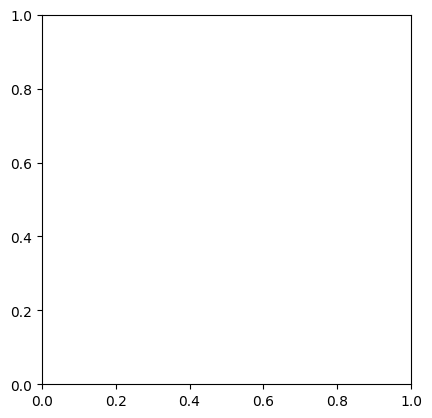

In [36]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

# --- Load model & processor ---
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)


image = images[0].convert("RGB")
text = ["cat feline animal"]

inputs = processor(text=text, images=image, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    vision_hidden = outputs.vision_model_output.last_hidden_state.squeeze(0)  # [num_patches+1, 768]
    text_hidden = outputs.text_model_output.last_hidden_state.squeeze(0)      # [seq_len, 512]

# --- Apply projection heads to put both into same space (512-D) ---
vision_proj = model.visual_projection(vision_hidden)  # [num_patches+1, 512]
text_proj = model.text_projection(text_hidden)        # [seq_len, 512]

# --- Drop CLS patch, normalize ---
patch_feats = vision_proj[1:]
patch_feats = patch_feats / patch_feats.norm(dim=-1, keepdim=True)
text_feats = text_proj / text_proj.norm(dim=-1, keepdim=True)
# --- Cosine similarity matrix ---
sim = patch_feats @ text_feats.T  # [num_patches, seq_len]

print(sim.shape)

# --- Visualize one token's patch map ---
num_patches = int(np.sqrt(sim.shape[0]))
for i in range(sim.shape[1]):
    plt.imshow(sim[:, i].reshape(num_patches, num_patches), cmap="viridis")
    plt.title(f"Token {i}")
    plt.axis("off")
    plt.show()

In [37]:
patch_feats.shape, text_feats.shape

(torch.Size([49, 512]), torch.Size([5, 512]))

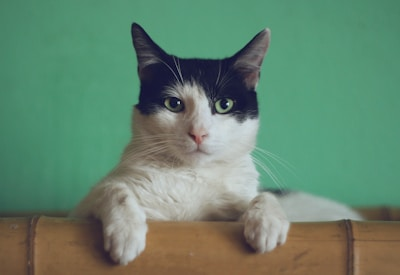

In [38]:
images[0]

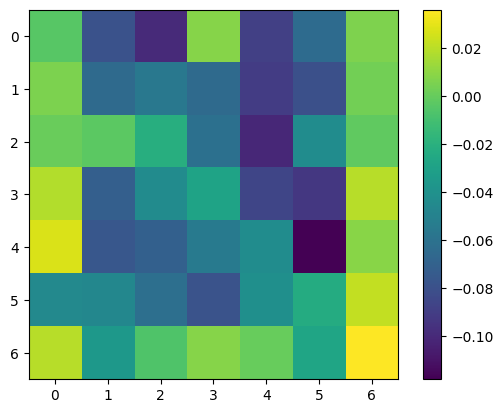

In [39]:
plt.imshow(sim[:, 1].reshape(num_patches, num_patches).detach().cpu().numpy())
plt.colorbar()

In [40]:
print(inputs['input_ids'])

tensor([[49406,  2368, 29471,  4668, 49407]])


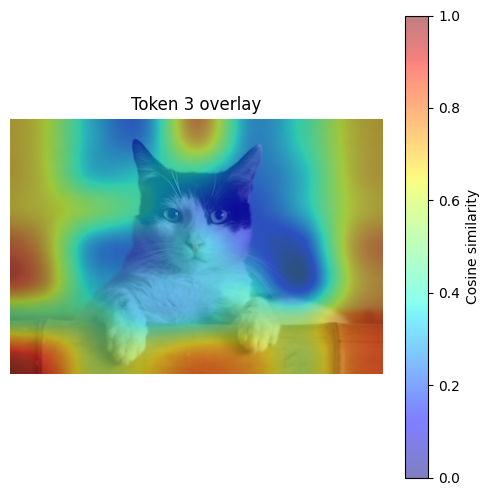

In [46]:
# --- choose token index ---
token_id = 3
num_patches = int(np.sqrt(sim.shape[0]))

# --- make heatmap ---
heatmap = sim[:, token_id].reshape(num_patches, num_patches).detach().cpu().numpy()

# --- resize heatmap to image size ---
H, W = image.size
heatmap = np.array(Image.fromarray(heatmap).resize((H, W), resample=Image.BICUBIC))

# --- normalize 0-1 ---
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- plot overlay ---
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # adjust alpha for transparency
plt.axis('off')
plt.title(f"Token {token_id} overlay")
plt.colorbar(label="Cosine similarity")
plt.show()

/var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/ipykernel_6976/1147860854.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


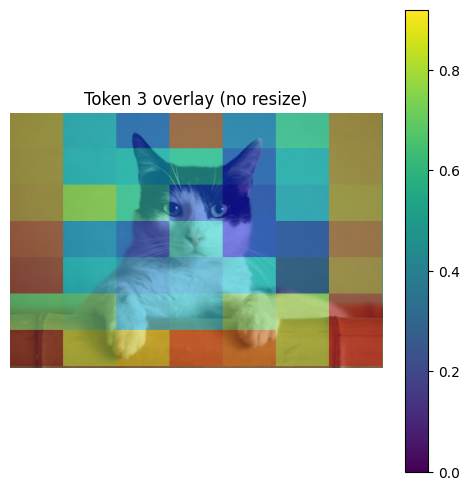

In [52]:

from matplotlib.colors import Normalize
from matplotlib import cm
token_id = 3
num_patches = int(np.sqrt(sim.shape[0]))  # e.g. 7x7 for ViT-B/32
patch_map = sim[:, token_id].detach().cpu().numpy().reshape(num_patches, num_patches)

# --- overlay on original image ---
img = np.array(image)
H, W, _ = img.shape
ph, pw = H // num_patches, W // num_patches

# normalize patch values to [0,1]
norm = Normalize(vmin=patch_map.min(), vmax=patch_map.max())
cmap = cm.get_cmap('jet')

overlay = img.copy().astype(float) / 255.0

for i in range(num_patches):
    for j in range(num_patches):
        color = np.array(cmap(norm(patch_map[i, j])))[:3]  # RGB
        overlay[i*ph:(i+1)*ph, j*pw:(j+1)*pw, :] = (
            0.6 * overlay[i*ph:(i+1)*ph, j*pw:(j+1)*pw, :] + 
            0.4 * color  # blending
        )

# --- plot ---
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Token {token_id} overlay (no resize)")

plt.colorbar()